## Import các thư viện cần thiết và đọc file

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import math
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, RobustScaler, StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, make_scorer, f1_score
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

In [3]:
customer_df = pd.read_csv('customer_data.csv')
payment_df = pd.read_csv('payment_data.csv') 

## Xem lướt qua dữ liệu

### payment_data.csv:
Lịch sử thanh toán thẻ của khách hàng.

- **id**: mã khách hàng
- **OVD_t1**: số lần quá hạn loại 1
- **OVD_t2**: số lần quá hạn loại 2
- **OVD_t3**: số lần quá hạn loại 3
- **OVD_sum**: tổng số ngày quá hạn
- **pay_normal**: số lần thanh toán bình thường
- **prod_code**: mã sản phẩm tín dụng
- **prod_limit**: hạn mức tín dụng của sản phẩm
- **update_date**: ngày cập nhật tài khoản
- **new_balance**: số dư hiện tại của sản phẩm
- **highest_balance**: số dư cao nhất trong lịch sử
- **report_date**: ngày thanh toán gần nhất

### customer_data.csv:
Dữ liệu nhân khẩu học và các thuộc tính danh mục của khách hàng đã được mã hóa.

- `fea_1`
- `fea_3`
- `fea_5`
- `fea_6`
- `fea_7`
- `fea_9`
- **label** là 1: khách hàng có rủi ro tín dụng cao
- **label** là 0: khách hàng có rủi ro tín dụng thấp

In [4]:
customer_df.head()

,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11
0,1,54982665,5,1245.5,3,77000.0,2,15,5,109,5,151300,244.948974
1,0,59004779,4,1277.0,1,113000.0,2,8,-1,100,3,341759,207.173840
2,0,58990862,7,1298.0,1,110000.0,2,11,-1,101,5,72001,1.000000
3,1,58995168,7,1335.5,1,151000.0,2,11,5,110,3,60084,1.000000
4,0,54987320,7,NaN,2,59000.0,2,11,5,108,4,450081,197.403141


In [5]:
payment_df.head()

,id,OVD_t1,OVD_t2,OVD_t3,OVD_sum,pay_normal,prod_code,prod_limit,update_date,new_balance,highest_balance,report_date
0,58987402,0,0,0,0,1,10,16500.0,04/12/2016,0.0,NaN,NaN
1,58995151,0,0,0,0,1,5,NaN,04/12/2016,588720.0,491100.0,NaN
2,58997200,0,0,0,0,2,5,NaN,04/12/2016,840000.0,700500.0,22/04/2016
3,54988608,0,0,0,0,3,10,37400.0,03/12/2016,8425.2,7520.0,25/04/2016
4,54987763,0,0,0,0,2,10,NaN,03/12/2016,15147.6,NaN,26/04/2016


In [6]:
print ('Customer Info:')
customer_df.info()

Customer Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125 entries, 0 to 1124
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   label   1125 non-null   int64  
 1   id      1125 non-null   int64  
 2   fea_1   1125 non-null   int64  
 3   fea_2   976 non-null    float64
 4   fea_3   1125 non-null   int64  
 5   fea_4   1125 non-null   float64
 6   fea_5   1125 non-null   int64  
 7   fea_6   1125 non-null   int64  
 8   fea_7   1125 non-null   int64  
 9   fea_8   1125 non-null   int64  
 10  fea_9   1125 non-null   int64  
 11  fea_10  1125 non-null   int64  
 12  fea_11  1125 non-null   float64
dtypes: float64(3), int64(10)
memory usage: 114.4 KB


In [7]:
print('Customer Describe:')
customer_df.describe()

Customer Describe:


,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11
count,1125.000000,1.125000e+03,1125.000000,976.000000,1125.000000,1.125000e+03,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000
mean,0.200000,5.783677e+07,5.482667,1283.911373,2.333333,1.208836e+05,1.928889,10.872000,4.832889,100.802667,4.195556,164618.495111,134.999004
std,0.400178,1.817150e+06,1.383338,51.764022,0.878773,8.844523e+04,0.257125,2.676437,2.971182,11.988955,0.855679,152520.488281,112.616798
min,0.000000,5.498235e+07,1.000000,1116.500000,1.000000,1.500000e+04,1.000000,3.000000,-1.000000,64.000000,1.000000,60000.000000,1.000000
25%,0.000000,5.499050e+07,4.000000,1244.000000,1.000000,7.200000e+04,2.000000,8.000000,5.000000,90.000000,3.000000,60044.000000,1.000000
50%,0.000000,5.898975e+07,5.000000,1281.500000,3.000000,1.020000e+05,2.000000,11.000000,5.000000,105.000000,4.000000,72000.000000,173.205081
75%,0.000000,5.899799e+07,7.000000,1314.500000,3.000000,1.390000e+05,2.000000,11.000000,5.000000,111.000000,5.000000,151307.000000,202.484567
max,1.000000,5.900624e+07,7.000000,1481.000000,3.000000,1.200000e+06,2.000000,16.000000,10.000000,115.000000,5.000000,650070.000000,707.106781


In [8]:
print("Payment Info:")
payment_df.info()

Payment Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8250 entries, 0 to 8249
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               8250 non-null   int64  
 1   OVD_t1           8250 non-null   int64  
 2   OVD_t2           8250 non-null   int64  
 3   OVD_t3           8250 non-null   int64  
 4   OVD_sum          8250 non-null   int64  
 5   pay_normal       8250 non-null   int64  
 6   prod_code        8250 non-null   int64  
 7   prod_limit       2132 non-null   float64
 8   update_date      8224 non-null   object 
 9   new_balance      8250 non-null   float64
 10  highest_balance  7841 non-null   float64
 11  report_date      7136 non-null   object 
dtypes: float64(3), int64(7), object(2)
memory usage: 773.6+ KB


In [9]:
print("Payment Describe: ")
payment_df.describe()

Payment Describe: 


,id,OVD_t1,OVD_t2,OVD_t3,OVD_sum,pay_normal,prod_code,prod_limit,new_balance,highest_balance
count,8.250000e+03,8250.000000,8250.000000,8250.000000,8250.000000,8250.000000,8250.000000,2132.000000,8.250000e+03,7.841000e+03
mean,5.782173e+07,0.249091,0.127152,0.369212,187.681697,14.526667,8.232000,85789.702205,1.054042e+05,2.192027e+05
std,1.822724e+06,1.250197,0.860046,2.900320,1804.232570,12.053627,3.533055,74345.828184,1.887704e+06,2.814536e+06
min,5.498235e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.100000,-4.030320e+04,5.010000e+02
25%,5.499050e+07,0.000000,0.000000,0.000000,0.000000,4.000000,6.000000,37400.000000,0.000000e+00,2.345300e+04
50%,5.898905e+07,0.000000,0.000000,0.000000,0.000000,11.000000,10.000000,68200.000000,0.000000e+00,4.404700e+04
75%,5.899655e+07,0.000000,0.000000,0.000000,0.000000,25.000000,10.000000,112200.000000,2.494800e+04,1.005000e+05
max,5.900624e+07,34.000000,34.000000,35.000000,31500.000000,36.000000,27.000000,660000.000000,1.632120e+08,1.800005e+08


In [10]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mz_table = mz_table[mz_table.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
        return mz_table

In [11]:
print("Chỉ in ra những cột nào thiếu trong bảng customer_df")
missing_values_table(customer_df)

Chỉ in ra những cột nào thiếu trong bảng customer_df


,Missing Values,% of Total Values
fea_2,149,13.2


In [12]:
print("Chỉ in ra những cột nào thiếu trong bảng payment_df")
missing_values_table(payment_df)

Chỉ in ra những cột nào thiếu trong bảng payment_df


,Missing Values,% of Total Values
prod_limit,6118,74.2
report_date,1114,13.5
highest_balance,409,5.0
update_date,26,0.3


## Xử lý theo phương án 1: Dùng dữ liệu nhân khẩu học để dự đoán

### Xử lý cơ bản trước khi đi vào phân tích

Bỏ cột "id" đi

In [13]:
customer_df.drop("id",axis=1,inplace=True)

Xử lý giá trị trùng lặp

In [14]:
customer_df.drop_duplicates(inplace=True)

### Khai phá dữ liệu

1. Xem số lượng giá trị của cột label 

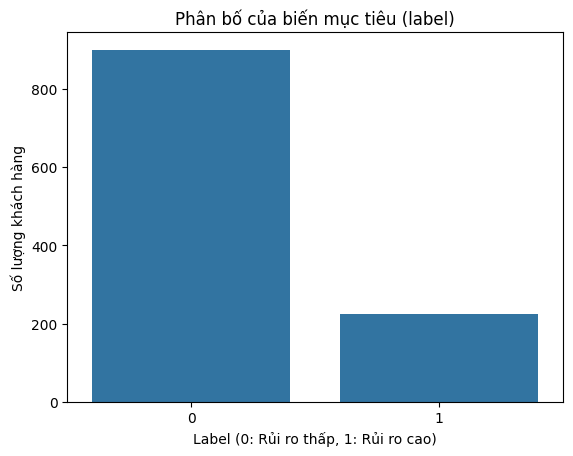

In [15]:
# Sử dụng seaborn.countplot để vẽ biểu đồ cột
sns.countplot(x='label', data=customer_df)

# Thêm tiêu đề và nhãn cho biểu đồ
plt.title('Phân bố của biến mục tiêu (label)')
plt.xlabel('Label (0: Rủi ro thấp, 1: Rủi ro cao)')
plt.ylabel('Số lượng khách hàng')

# Hiển thị biểu đồ
plt.show()


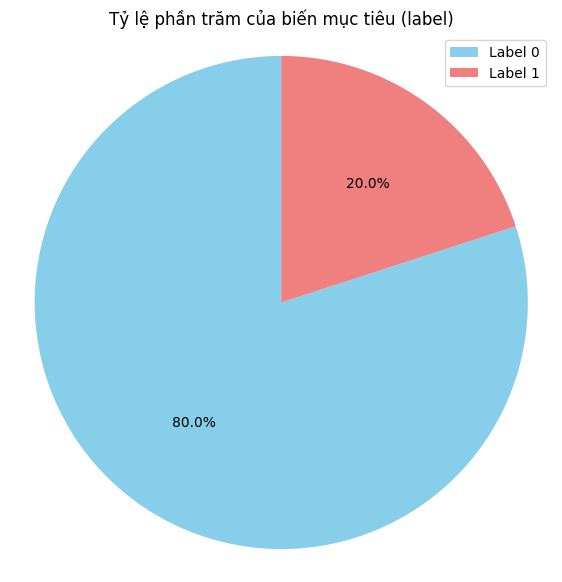

In [16]:
# Tính số lượng cho mỗi giá trị trong cột 'label'
label_counts = customer_df['label'].value_counts()

# Tính tỷ lệ phần trăm
label_percentages = (label_counts / label_counts.sum()) * 100

# Tạo nhãn cho các phần của biểu đồ (chỉ cần giá trị 0 và 1 cho legend)
pie_labels = label_percentages.index.map(lambda x: f'Label {x}')

# Vẽ biểu đồ hình tròn
plt.figure(figsize=(7, 7)) # Tùy chỉnh kích thước biểu đồ
plt.pie(
    label_percentages,
    autopct='%1.1f%%', # Hiển thị phần trăm trực tiếp trên biểu đồ
    startangle=90,
    colors=['skyblue', 'lightcoral'] # Gán màu cho từng phần
)

# Thêm tiêu đề
plt.title('Tỷ lệ phần trăm của biến mục tiêu (label)')

# Thêm chú thích màu (legend)
plt.legend(pie_labels, loc="best") # Sử dụng pie_labels cho legend

# Đảm bảo biểu đồ là hình tròn
plt.axis('equal')

# Hiển thị biểu đồ
plt.show()

2. Xem heatmap

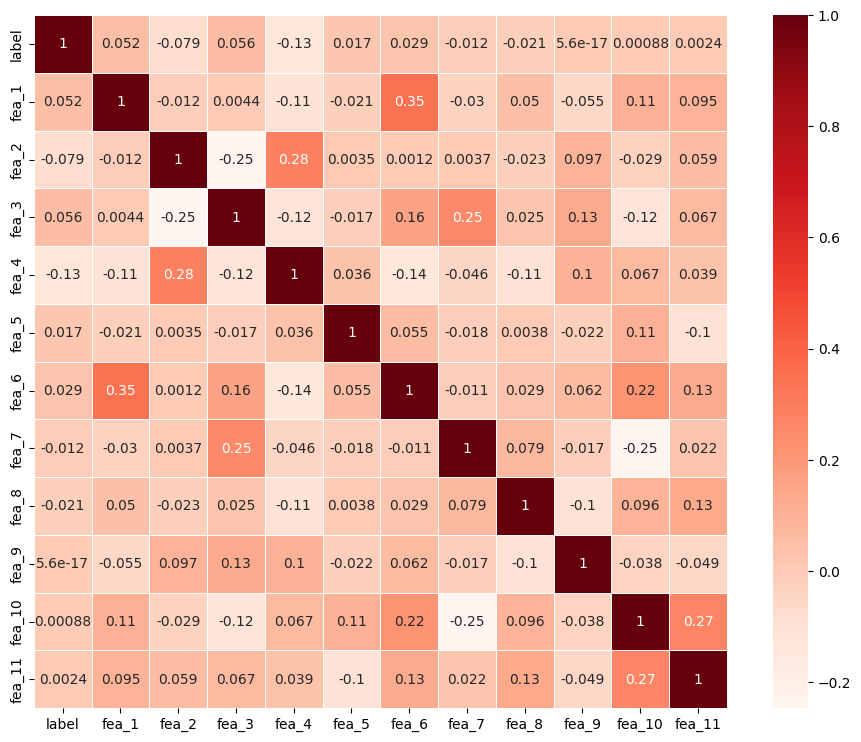

In [17]:
correlation_matrix = customer_df.corr()
fig = plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix,annot=True,square=True, linewidths=.5,cmap=plt.cm.Reds)
plt.show()

--> Không có cặp đặc trưng nào có tương quan cực kỳ mạnh (ví dụ > 0.8 hoặc < -0.8) đến mức gây ra vấn đề nghiêm trọng về đa cộng tuyến cho hầu hết các mô hình. Tuy nhiên, các mối tương quan ở mức trung bình như fea_1 và fea_6 cần được lưu ý. Đối với các mô hình như hồi quy tuyến tính, đa cộng tuyến có thể ảnh hưởng đến việc diễn giải hệ số. Đối với các mô hình dựa trên cây (như Random Forest), nó ít gây vấn đề hơn về mặt hiệu suất dự đoán nhưng có thể ảnh hưởng đến tầm quan trọng của đặc trưng.

--> Nếu ta để ý vào dòng đầu tiên (label) ta sẽ thấy là các feature có vẻ như ko có mqh tuyến tính với target của chúng ta, vậy nên việc sử dụng mô hình logistic regression để phân loại có vẻ là không khả thi cho lắm

3. Xem phân phối của các cột

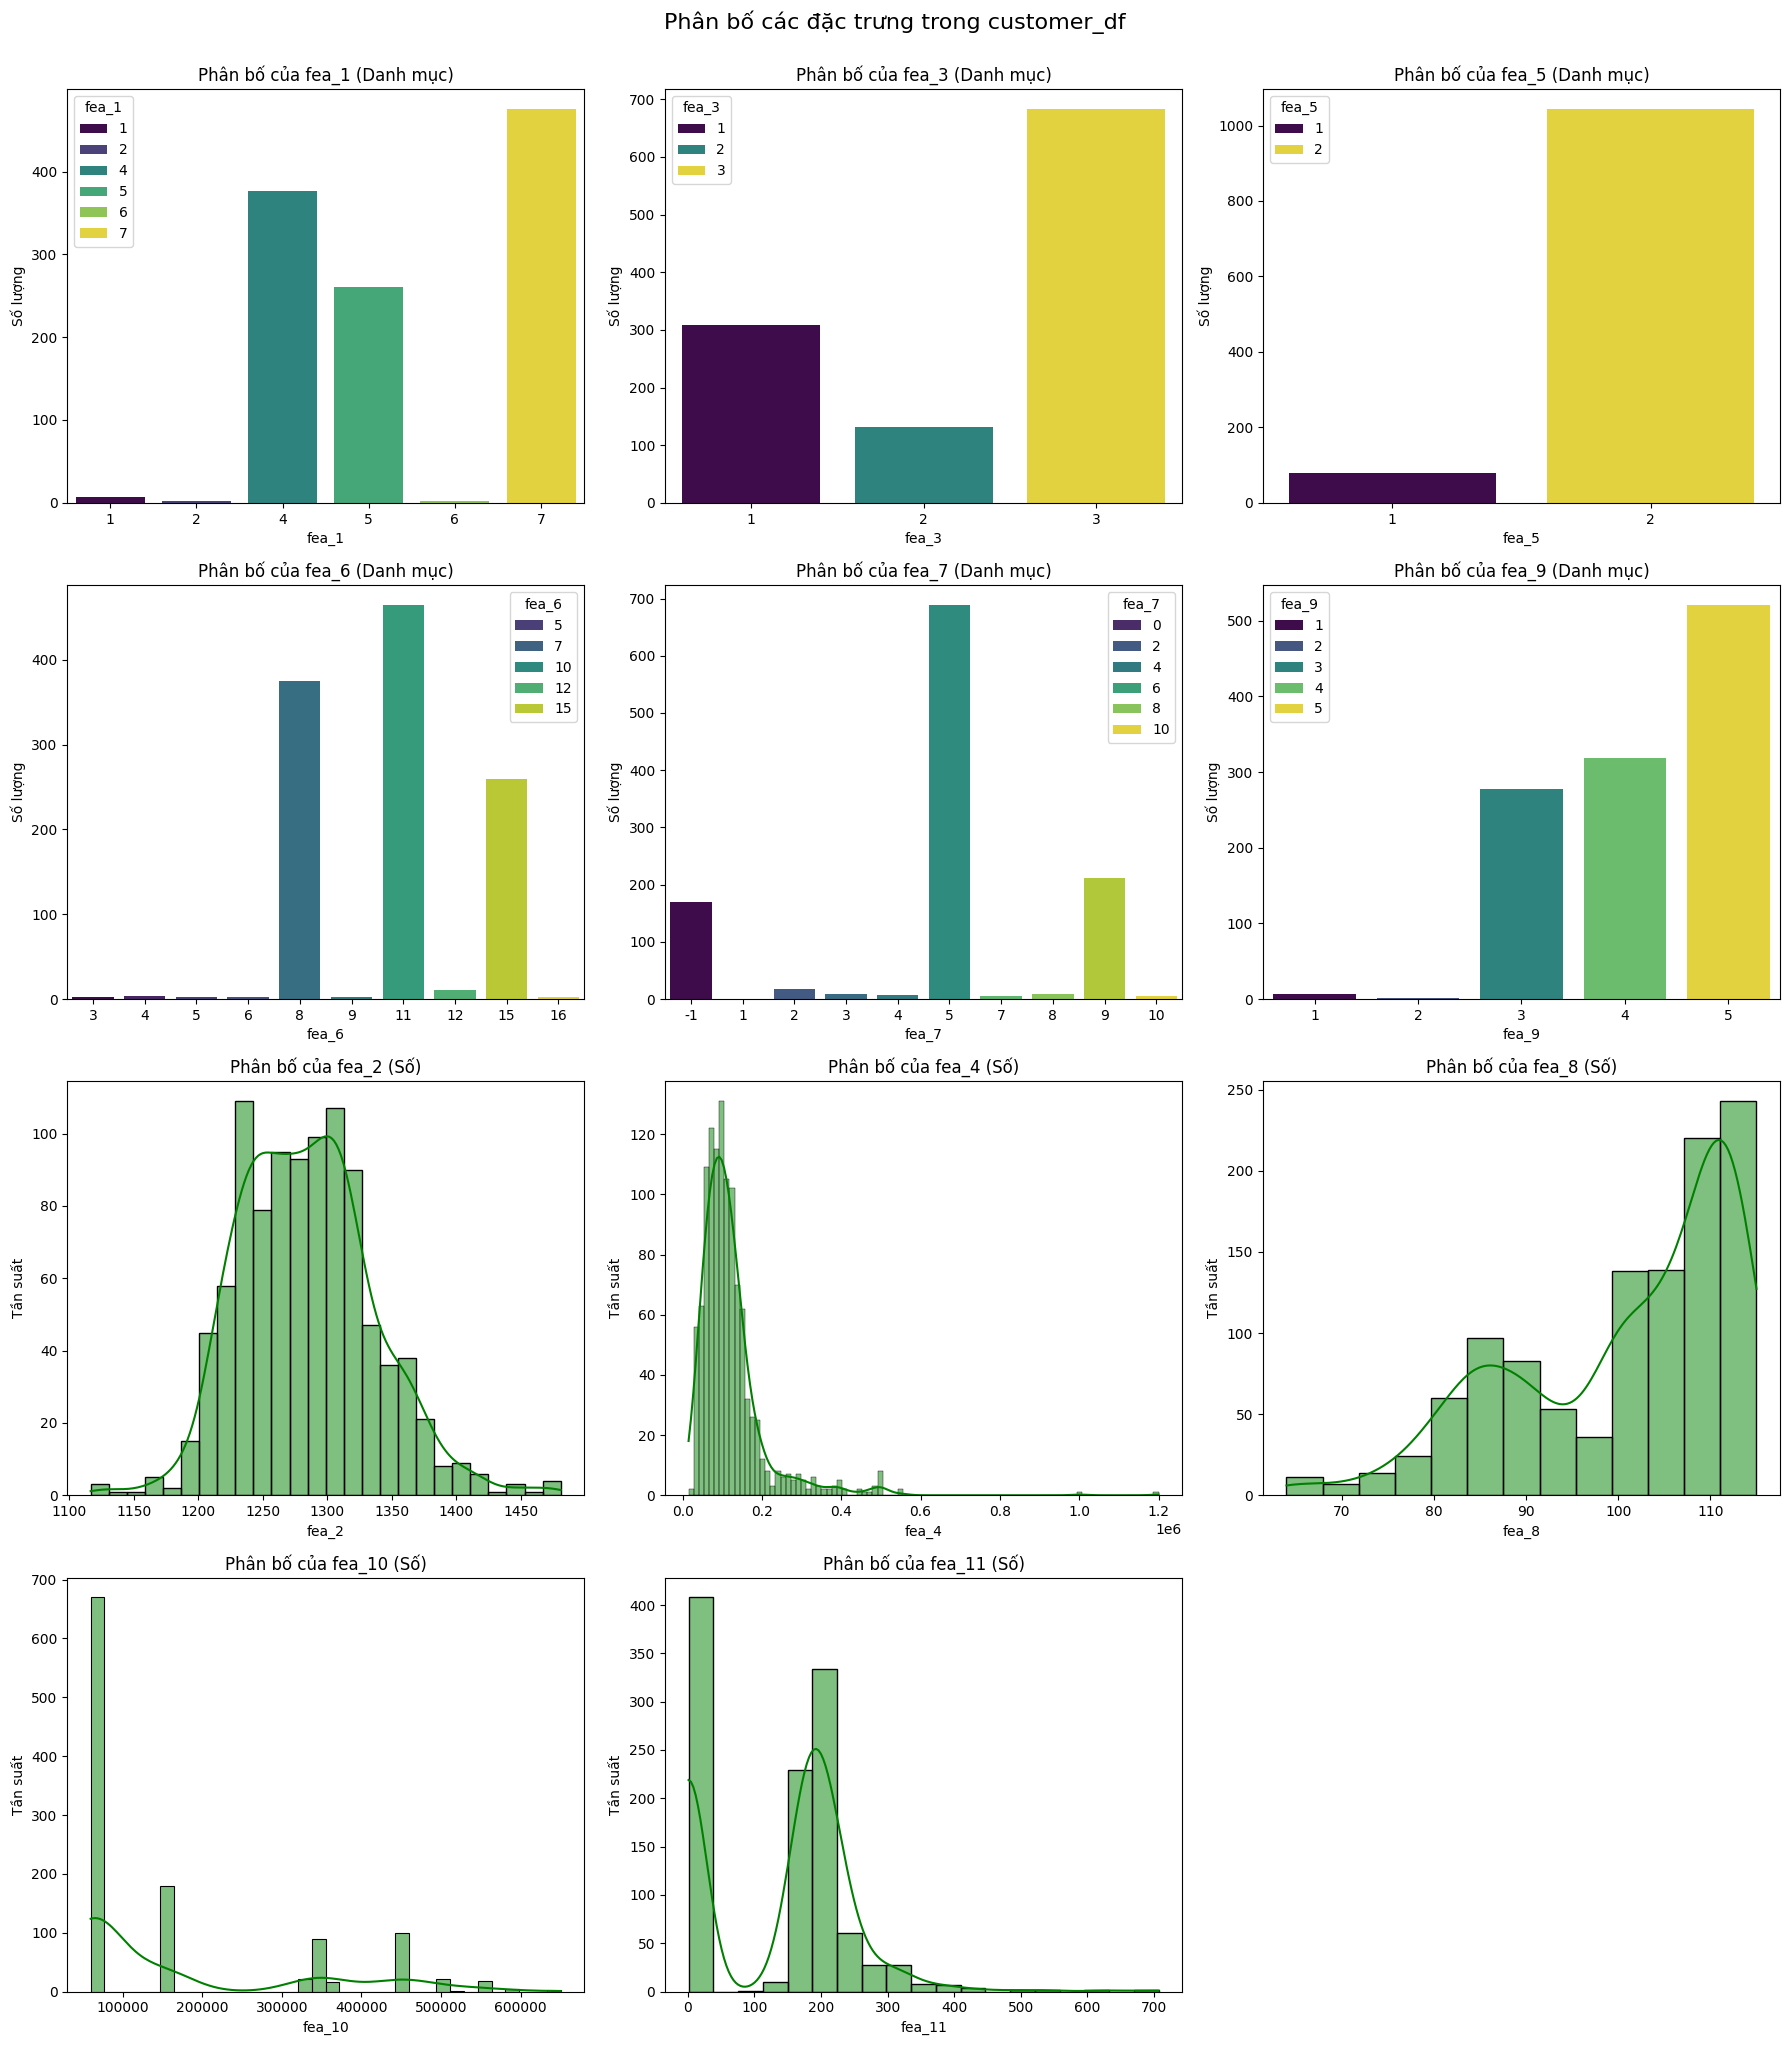

In [18]:


# Xác định các cột danh mục và cột số trong customer_df
categorical_cols = ['fea_1', 'fea_3', 'fea_5', 'fea_6', 'fea_7', 'fea_9']
numerical_cols = ['fea_2', 'fea_4', 'fea_8', 'fea_10', 'fea_11'] # Các cột số còn lại

# Kết hợp danh sách các cột để lặp qua
all_cols_to_plot = categorical_cols + numerical_cols

# Số cột trên mỗi hàng
n_cols = 3

# Tính toán số hàng cần thiết
n_rows = math.ceil(len(all_cols_to_plot) / n_cols)

# Tạo figure và lưới các subplot
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 5)) # Tùy chỉnh kích thước figure

# Làm phẳng mảng axes nếu có nhiều hơn 1 hàng
axes = axes.flatten()

# Lặp qua từng cột và vẽ biểu đồ phù hợp trên subplot tương ứng
for i, col in enumerate(all_cols_to_plot):
    ax = axes[i] # Lấy subplot hiện tại

    if col in categorical_cols:
        # Vẽ biểu đồ cột cho cột danh mục
        sns.countplot(data=customer_df, x=col, ax=ax, palette='viridis',hue=col) # Sử dụng countplot
        ax.set_title(f'Phân bố của {col} (Danh mục)')
        ax.set_xlabel(col)
        ax.set_ylabel('Số lượng')
    elif col in numerical_cols:
        # Vẽ biểu đồ histogram với KDE cho cột số
        sns.histplot(data=customer_df, x=col, ax=ax, kde=True, color='green') # Sử dụng histplot
        ax.set_title(f'Phân bố của {col} (Số)')
        ax.set_xlabel(col)
        ax.set_ylabel('Tần suất')
    # Bạn có thể thêm các trường hợp khác nếu có loại cột khác

# Ẩn các subplot không sử dụng
for j in range(len(all_cols_to_plot), len(axes)):
    fig.delaxes(axes[j])

# Điều chỉnh layout để tránh chồng lấn
plt.tight_layout()

# Thêm tiêu đề chung cho toàn bộ hình (tùy chọn)
plt.suptitle('Phân bố các đặc trưng trong customer_df', y=1.02, fontsize=16)

# Hiển thị biểu đồ
plt.show()


##### Nhận xét:
+ Xét những giá trị dạng danh mục:  
1. Đối với những giá trị chữ, có sự mất cân bằng lớn, có một vài giá trị chiếm đa số. Điều này có thể ảnh hưởng đến khả năng học của mô hình đối với các lớp thiểu số  
2. Cột fea_6 có tính đa dạng thấp nhất (2 giá trị), trong khi fea_6 và fea_7 có nhiều giá trị hơn  
3. Để ý cột fea_7 có tồn tại giá trị -1. Đây có thể là kết quả của việc người cung cấp dữ liệu đã thay các giá trị null bằng -1. Tuy nhiên để hiểu rõ -1 có ý nghĩa gì thì chúng ta cần phải hỏi người tạo ra dữ liệu này !
+ Đối với những giá trị số:  
1. Đối với fea_2 thì phân phối khá đẹp, có vẻ như ít giá trị ngoại lai xuất hiện.  
2. fea_4 và fea_10 bị lệch mạnh, có thể ảnh hưởng đến các mô hình nhạy cảm với phân phối dữ liệu như là hồi quy tuyến tính, SVM, ... Nó tồn tại rất nhiều giá trị ngoại lai.  
3. Đối với fea_8 và fea_11 thì ta thấy nhiều đỉnh, gợi ý cho ta sự tồn tại của các nhóm con hoặc cụm con trong dữ liệu


4. Phân tích các cột số

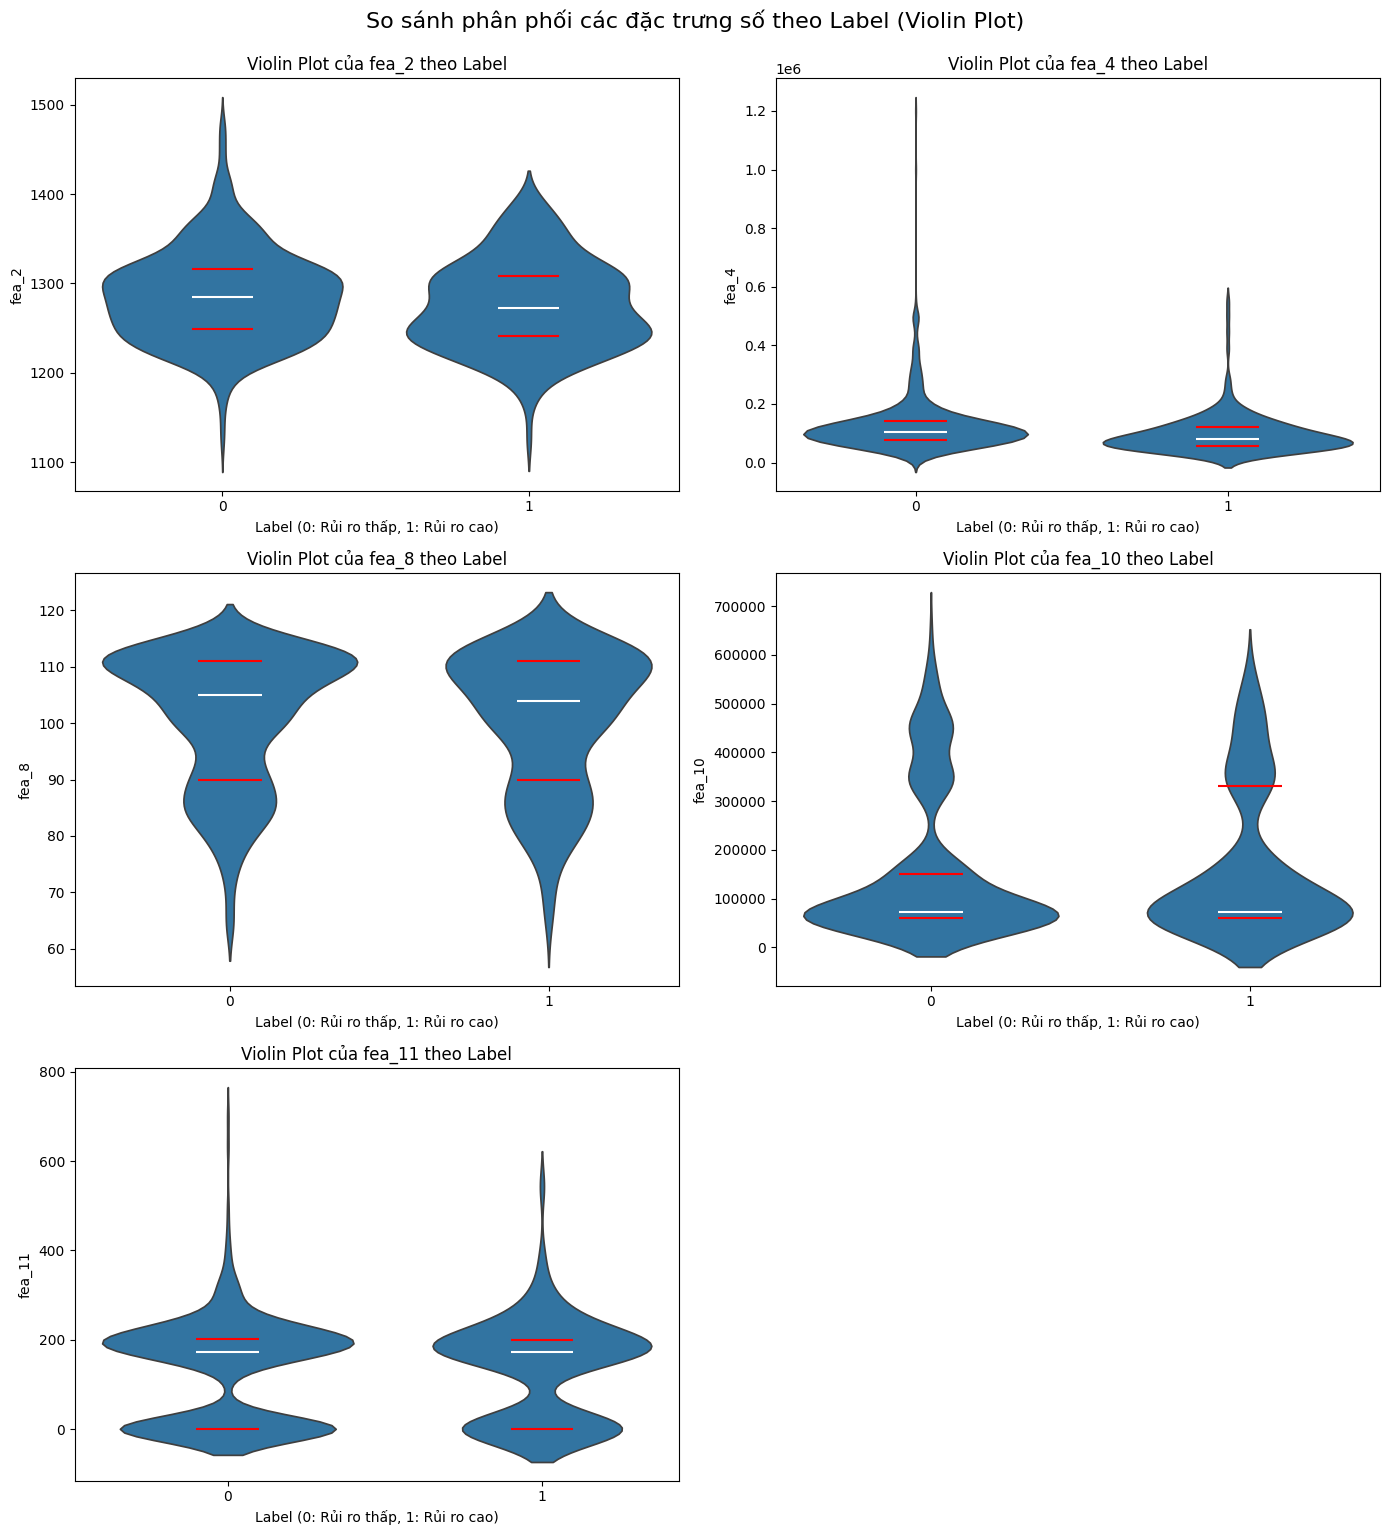

In [19]:
# Giả sử customer_df đã được load

# Danh sách các cột cần vẽ violin plot
violin_cols = ['fea_2', 'fea_4', 'fea_8', 'fea_10', 'fea_11']

# Số cột trên mỗi hàng khi vẽ
n_cols = 2 # Bạn có thể điều chỉnh số này

# Tính toán số hàng cần thiết
n_rows = math.ceil(len(violin_cols) / n_cols)

# Tạo figure và lưới các subplot
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 5)) # Tùy chỉnh kích thước figure

# Làm phẳng mảng axes nếu có nhiều hơn 1 hàng
axes = axes.flatten()

# Tính toán các tứ phân vị cho từng cột và từng nhóm label
quartiles_dict = {}
for col in violin_cols:
    # Tính Q1 (0.25), Median (0.5), Q3 (0.75) cho từng cột, gom nhóm theo 'label'
    quartiles_dict[col] = customer_df.groupby('label')[col].quantile([0.25, 0.5, 0.75]).unstack()
    # Kết quả sẽ là một DataFrame với index là label (0, 1) và cột là các tứ phân vị (0.25, 0.5, 0.75)

# Định nghĩa màu cho median và quartiles
median_color = 'white' # Màu nổi bật cho median
quartile_color = 'red' # Màu đỏ cho Q1 và Q3

# Lặp qua từng cột số và vẽ violin plot theo nhóm label
for i, col in enumerate(violin_cols):
    ax = axes[i] # Lấy subplot hiện tại

    # Vẽ violin plot KHÔNG CÓ inner='quartile'
    sns.violinplot(
        data=customer_df,
        x='label',
        y=col,
        ax=ax,
        inner=None # Không vẽ gì bên trong để vẽ thủ công sau
    )

    # Lấy các giá trị tứ phân vị đã tính cho label 0 và label 1
    q1_l0, median_l0, q3_l0 = quartiles_dict[col].loc[0, [0.25, 0.5, 0.75]]
    q1_l1, median_l1, q3_l1 = quartiles_dict[col].loc[1, [0.25, 0.5, 0.75]]

    # Vẽ thủ công các đường ngang cho tứ phân vị và median
    # Các vị trí x cho label 0 và 1 trên trục categorical thường là 0 và 1
    # Chúng ta vẽ các đường ngang nhỏ xung quanh các vị trí x này

    # Cho label 0 (vị trí x = 0)
    ax.hlines(y=q1_l0, xmin=-0.1, xmax=0.1, color=quartile_color, linestyle='-', linewidth=1.5)
    ax.hlines(y=median_l0, xmin=-0.1, xmax=0.1, color=median_color, linestyle='-', linewidth=1.5)
    ax.hlines(y=q3_l0, xmin=-0.1, xmax=0.1, color=quartile_color, linestyle='-', linewidth=1.5)

    # Cho label 1 (vị trí x = 1)
    ax.hlines(y=q1_l1, xmin=0.9, xmax=1.1, color=quartile_color, linestyle='-', linewidth=1.5)
    ax.hlines(y=median_l1, xmin=0.9, xmax=1.1, color=median_color, linestyle='-', linewidth=1.5)
    ax.hlines(y=q3_l1, xmin=0.9, xmax=1.1, color=quartile_color, linestyle='-', linewidth=1.5)


    ax.set_title(f'Violin Plot của {col} theo Label') # Đặt tiêu đề cho từng subplot
    ax.set_xlabel('Label (0: Rủi ro thấp, 1: Rủi ro cao)')
    ax.set_ylabel(col)

# Ẩn các subplot không sử dụng nếu số cột không chia hết cho 2
for j in range(len(violin_cols), len(axes)):
    fig.delaxes(axes[j])

# Điều chỉnh layout để tránh chồng lấn
plt.tight_layout()

# Thêm tiêu đề chung cho toàn bộ hình (tùy chọn)
plt.suptitle('So sánh phân phối các đặc trưng số theo Label (Violin Plot)', y=1.02, fontsize=16)

# Hiển thị biểu đồ
plt.show()


##### Insight:
Dựa vào hình trên, ta thấy được rằng với tất cả các fea (ngoại trừ fea_10) dường như cả về hình dáng và vị trí tứ phân vị trên và dưới đồng thời cả median có vẻ như không có sự khác biệt (chỉ ngoại trừ việc ở các label 0 thì các fea có xu hướng có nhiều outliers hơn 
+ Ở fea_10 thực tế hình dáng label 0 và 1 thực tế trông cũng giống nhau. Song, khác biệt là ở tứ phân vị trên, ta thấy được rằng 50% giá trị của label 0 tập trung khoảng từ 90000 đến 160000. Trong khi khoảng của label 1 lại rộng hơn (KHOẢNG TỪ 90000 đến 35000
0). Biến này có vẻ ít nhiều ảnh hưởng đến target bởi ta có thể hiểu nôm na rằng là: do label 1 có khoảng 50% rộng hơn, tức là với giá trị fea_10 cao hơn thì dễ có xu hướng là rơi vào label 1. Tuy nhiên điều này thực tế cũng khá mơ hồ, không đủ chắc chắn bởi hình dáng của 2 đồ thị tương ứng với label 0 và label 1 là khá giống nhau

##### Tóm lại: Ta cần để tâm đến fea_10

5. Phân tích các cột chữ

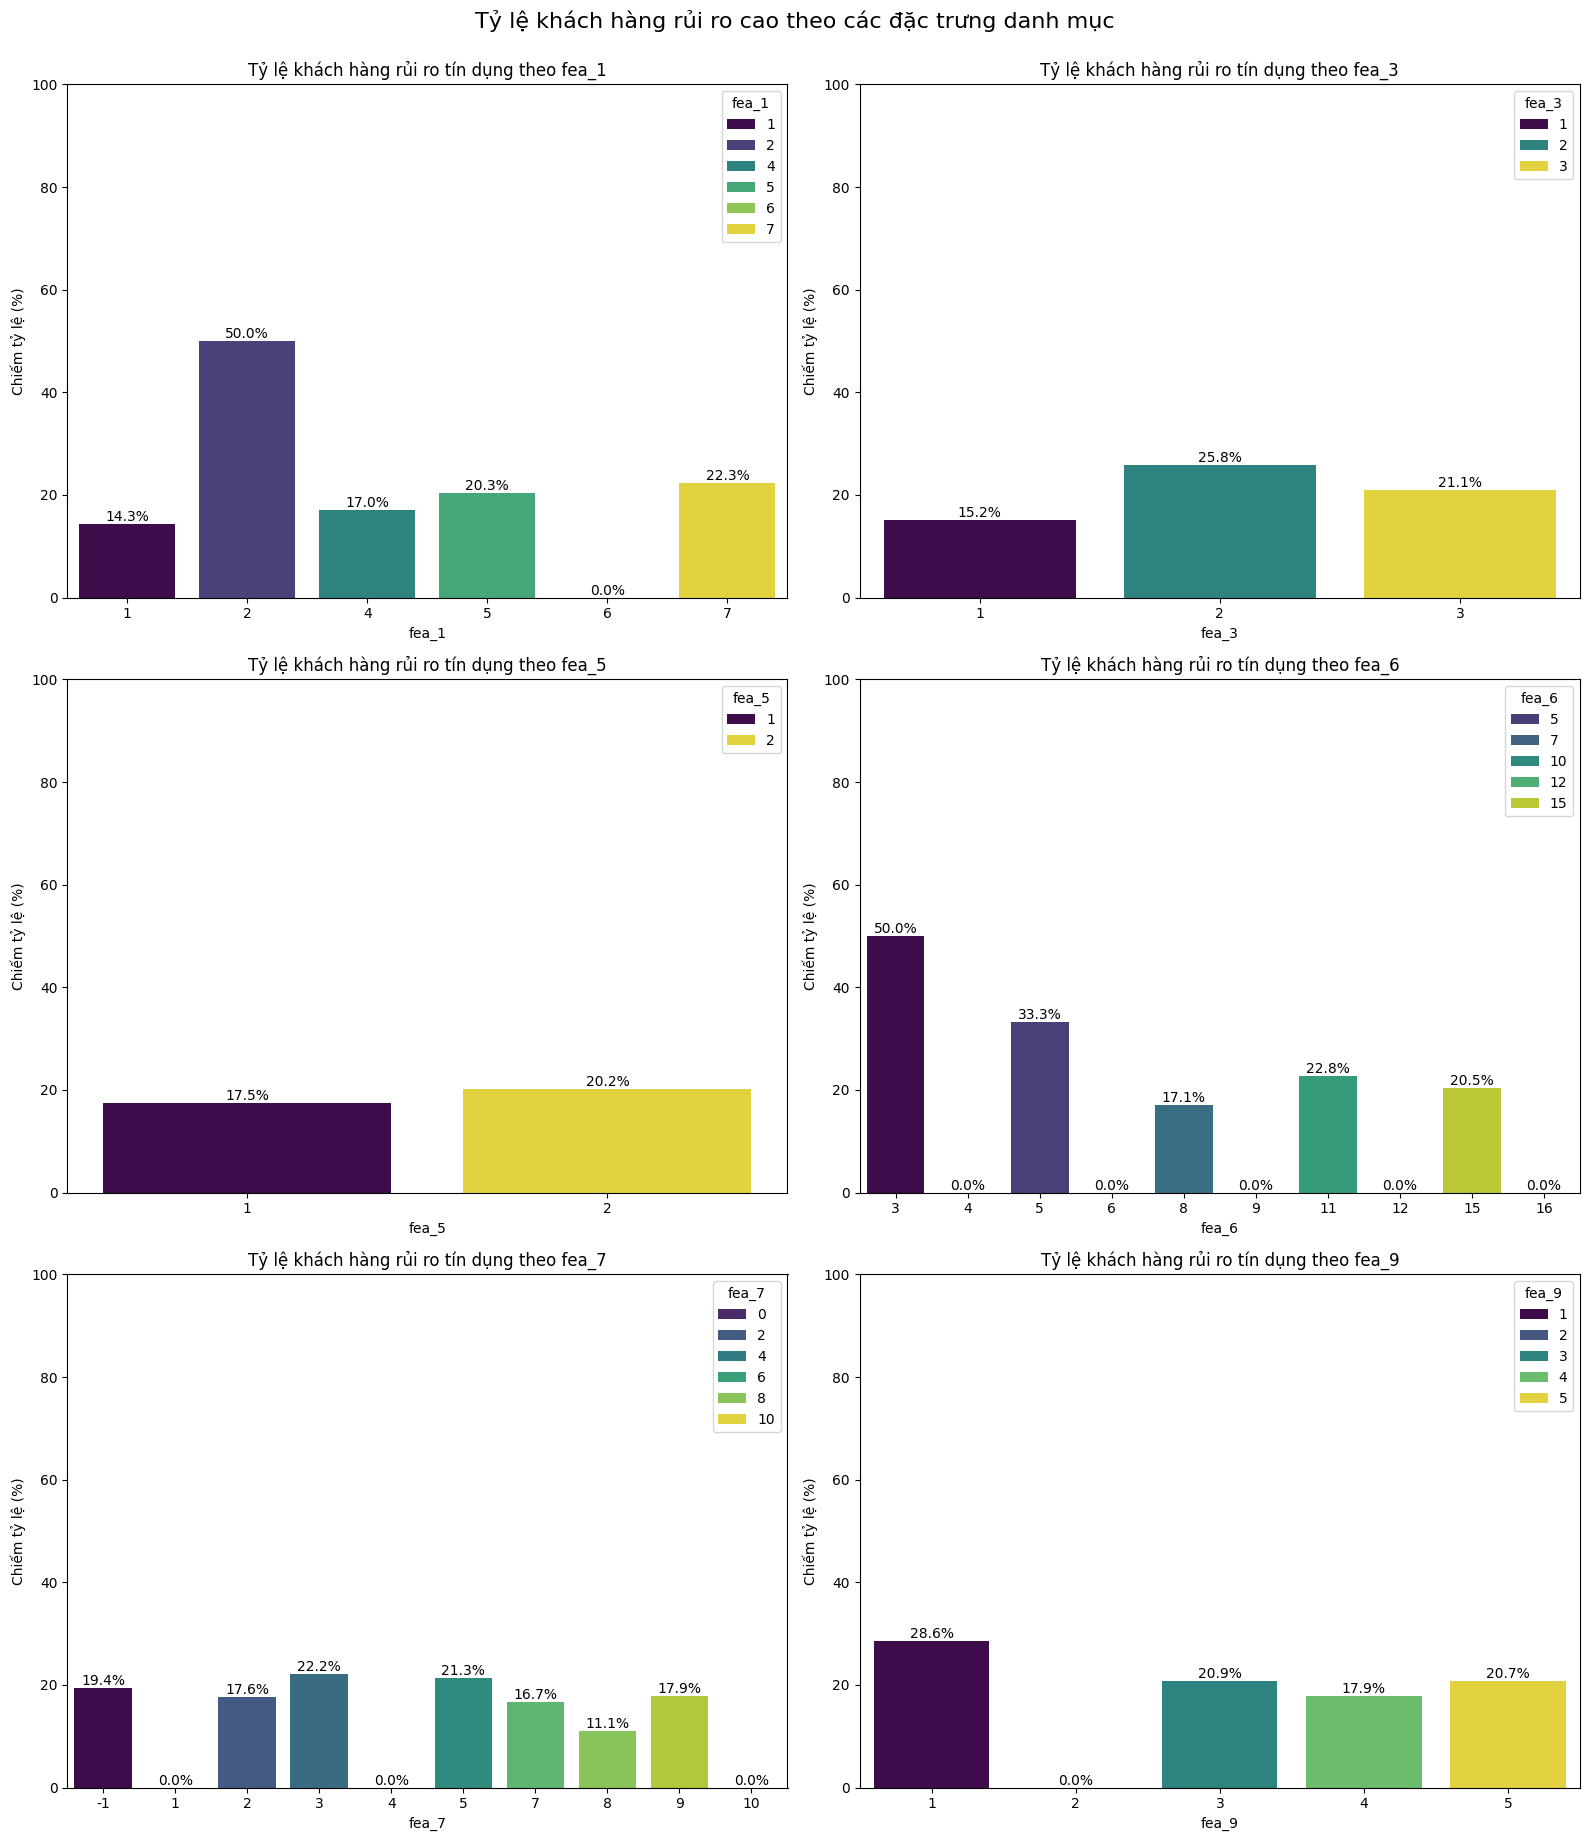

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd # Đảm bảo pandas đã được import
import math # Cần cho tính toán số hàng

# Giả sử customer_df đã được load

# Xác định các cột danh mục
categorical_cols = ['fea_1', 'fea_3', 'fea_5', 'fea_6', 'fea_7', 'fea_9']

# Số cột trên mỗi hàng khi vẽ
n_cols = 2 # Sử dụng 2 cột mỗi hàng để biểu đồ dễ nhìn hơn

# Tính toán số hàng cần thiết
n_rows = math.ceil(len(categorical_cols) / n_cols)

# Tạo figure và lưới các subplot
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 6)) # Tùy chỉnh kích thước figure

# Làm phẳng mảng axes nếu có nhiều hơn 1 hàng
axes = axes.flatten()

# Lặp qua từng cột danh mục và vẽ biểu đồ tỷ lệ rủi ro
for i, col in enumerate(categorical_cols):
    ax = axes[i] # Lấy subplot hiện tại

    # Tính toán tỷ lệ khách hàng rủi ro cao (label=1) cho mỗi nhóm trong cột danh mục
    # Trung bình của cột 'label' (0/1) chính là tỷ lệ của giá trị 1
    risk_rate_by_category = customer_df.groupby(col)['label'].mean().reset_index()

    # Vẽ biểu đồ barplot
    sns.barplot(
        data=risk_rate_by_category,
        x=col,
        y=risk_rate_by_category['label']*100, # Trục y là tỷ lệ rủi ro (đã nhân 100)
        ax=ax,
        palette='viridis',
        hue=col
    )

    ax.set_title(f'Tỷ lệ khách hàng rủi ro tín dụng theo {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Chiếm tỷ lệ (%)') # Nhãn trục y rõ ràng hơn
    ax.set_ylim(0, 100) # Giới hạn trục y từ 0 đến 100

    # Hiển thị tỷ lệ phần trăm trên đỉnh cột
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', label_type='edge')


# Ẩn các subplot không sử dụng
for j in range(len(categorical_cols), len(axes)):
    fig.delaxes(axes[j])

# Điều chỉnh layout để tránh chồng lấn
plt.tight_layout()

# Thêm tiêu đề chung cho toàn bộ hình (tùy chọn)
plt.suptitle('Tỷ lệ khách hàng rủi ro cao theo các đặc trưng danh mục', y=1.02, fontsize=16)

# Hiển thị biểu đồ
plt.show()

##### Insight:
+ Ở fea_1, ta thấy giá trị 2 vượt trội hơn cả. Đó là 1 tín hiệu tốt (tức nhiều người mắc credit risk tại fea_1 bằng 2). Tuy nhiên, ở giá trị 6 thì ta thấy nó chiếm 0,0%, cái này ta cần xác minh được vì biết đâu người được hỏi (người đó mang giá trị fea_1 = 6) là rất ít (chỉ có 1,2 người) chẳng hạn. Vậy nên tại giá trị 6 ở fea_1 ta chưa thể kết luận rằng nếu 1 người mang fea_1 = 6 thì sẽ không bị credit risk được
+ Ở fea_3 thì người nào đạt giá trị 2 thì rủi ro hơn, còn 1 ít rủi ro nhất. Tuy nhiên biến này có ít thông tin đủ mạnh để phán đoán khả năng cao 1 người bị credit risk hay không
+ Ở fea_5 thì giá trị 1,2 có tỷ lệ khá sát nhau. Vậy nên thực tế fea_5 này không đủ mạnh để đưa ra thông tin để ta phân biệt giữa 2 lớp 0/1
+ Ở fea_6 có sự phân cấp khá rõ ràng, với giá trị 3 chiếm 50%. Cho thấy khả năng tiên đoán khá mạnh của giá trị này. Giá trị 5 cũng cho ta khả năng tiên đoán tốt. Tuy nhiên ở đây ta lại phải lưu ý các giá trị như 4,6,9,12,16. Cần kiểm tra số lượng mẫu cho các giá trị này.
+ Ở fea_7, các giá trị phân cấp không rõ ràng, khá đều. Ít có khả năng tiên đoán 0/1. Tuy vậy vẫn cần lưu tâm giá trị 1 và 4 (0%)
+ Ở fea_9 cũng giống fea_7. Cần lưu tâm giá trị 2  
##### Tóm lại:  Ta cần lưu tâm fea_1 và fea_6 là các biến có ảnh hưởng khá mạnh. Mặt khác, ta cũng cần đi kiểm tra các giá trị chứa 0% kia

##### Tìm hiểu về con số 0%

In [21]:
import pandas as pd
from prettytable import PrettyTable # Import lớp PrettyTable

# Giả sử customer_df đã được load

# Danh sách các cặp (cột, giá trị) có tỷ lệ rủi ro 0.0%
zero_risk_values = {
    'fea_1': [6],
    'fea_6': [4, 6, 9, 12, 16],
    'fea_7': [1, 4, 6, 8, 10],
    'fea_9': [2]
}

# Lấy tổng số dòng trong DataFrame
total_rows = len(customer_df)

# Tạo một đối tượng PrettyTable
table = PrettyTable()

# Định nghĩa tiêu đề cho các cột, thêm cột mới
table.field_names = ["Cột danh mục", "Giá trị", "Số lượng xuất hiện", "Chiếm % trong tổng số dòng"]

# Lặp qua từng cột và giá trị có tỷ lệ rủi ro 0.0%
for col, values in zero_risk_values.items():
    for value in values:
        # Đếm số lần xuất hiện của giá trị cụ thể trong cột
        count = customer_df[customer_df[col] == value].shape[0]

        # Tính tỷ lệ phần trăm so với tổng số dòng
        percentage = (count / total_rows) * 100

        # Định dạng tỷ lệ phần trăm thành chuỗi
        percentage_str = f"{percentage:.2f}%" # Định dạng 2 chữ số thập phân

        # Thêm một hàng vào bảng
        table.add_row([col, value, count, percentage_str])

# In bảng
print("Số lượng xuất hiện và tỷ lệ của các giá trị có tỷ lệ rủi ro 0.0%:")
print(table)


Số lượng xuất hiện và tỷ lệ của các giá trị có tỷ lệ rủi ro 0.0%:
+--------------+---------+--------------------+----------------------------+
| Cột danh mục | Giá trị | Số lượng xuất hiện | Chiếm % trong tổng số dòng |
+--------------+---------+--------------------+----------------------------+
|    fea_1     |    6    |         2          |           0.18%            |
|    fea_6     |    4    |         4          |           0.36%            |
|    fea_6     |    6    |         2          |           0.18%            |
|    fea_6     |    9    |         2          |           0.18%            |
|    fea_6     |    12   |         11         |           0.98%            |
|    fea_6     |    16   |         2          |           0.18%            |
|    fea_7     |    1    |         1          |           0.09%            |
|    fea_7     |    4    |         7          |           0.62%            |
|    fea_7     |    6    |         0          |           0.00%            |
|    fea_7

##### Nhận xét: 
Chiếm toàn 0. mấy phần trăm. Tức là rất rất rất rất là ít, tức là phỏng vấn rất ít người mang các giá trị đặc biệt như trên. Và phỏng vấn mấy người đó thì đều là những người không bị credit risk. Chứng tỏ chúng ta chưa thể nhìn vào con số 0% đó rồi kết luận rằng người đó không bị credit risk nếu rơi vào nhóm như trên được

#### Tóm lại:
Qua phần EDA cơ bản này ta tìm ra được một vài điều quan trọng sau: 
1. Biến mục tiêu có số lượng mẫu bị chênh lệch, không cân đối (giá trị 0 áp đảo so với giá trị 1)
2. Có một vài cột chữ tồn tại những giá trị có tần suất xuất hiện nhiều vượt trội so với những cột còn lại. Có thể ảnh hưởng đến khả năng học của mô hình.
3. Các giá trị số thì đa phần phân phối là lệch, tồn tại nhiều giá trị ngoại lệ. Mặt khác còn tồn tại một vài cột có phân phối xuất hiện nhiều đỉnh nhấp nhô. Gợi ý ta việc phân chia các nhóm nhỏ để dự đoán riêng cho từng nhóm nhỏ đó.
4. Với việc phân tích sự ảnh hưởng của các cột số đến target, ta nhận thấy được cột fea_10 có ảnh hưởng không nhỏ đến target (là các biến đáng lưu tâm)
5. Với việc phân tích sự ảnh hưởng của các cột chữ đến target, ta nhận thấy được cột fea_1 và fea_6 ảnh hưởng không nhỏ đến target (là các biến đáng lưu tâm)
6. Có một vài giá trị trong các cột là 0% cho label=1, tuy nhiên không hề có ích trong việc dự đoán do số lượng mẫu của các giá trị ấy là nhỏ
7. Tồn tại số -1 ở fea_7 có thể là null

### Data Preparation

Xử lý số -1 ở fea_7

In [22]:
# Tạo một cột mới chỉ ra rằng là liệu ở hàng nào thì tồn tại fea_7 = -1
customer_df['fea_7_is_minus_one'] = (customer_df['fea_7'] == -1).astype(int)

Xác định các nhóm cột

In [23]:
numerical_cols_highly_skewed = ['fea_4', 'fea_10', 'fea_11']
numerical_cols_mildly_skewed_or_normal = ['fea_2', 'fea_8']
categorical_cols_original = ['fea_1', 'fea_3', 'fea_5', 'fea_6', 'fea_9']
fea7_col_to_impute = ['fea_7']
indicator_col_passthrough = ['fea_7_is_minus_one']

1. Chia tập dữ liệu

In [24]:
X = customer_df.drop('label', axis=1)
y = customer_df['label']

In [25]:
# Chia để đảm bảo tỷ lệ của 0/1 giống với gốc
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

2. Tạo các pipeline

In [26]:
# Transformer cho log transform
log_transformer = FunctionTransformer(np.log1p, validate=False)

# Pipeline cho các cột số có thể bị lệch và có outliers (ví dụ: fea_4, fea_10)
highly_skewed_numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # Impute trước khi transform
    ('log_transform', log_transformer),
    ('scaler', RobustScaler()) # RobustScaler tốt cho outliers
])

# Pipeline cho các cột số khác (có phân phối gần chuẩn)
other_numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # fea_2 có NaN
    ('scaler', StandardScaler())
])

fea7_imputation_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=-1)) # Coi -1 là giá trị cần impute
])

3. Tạo ColumnTransformer

In [27]:
# c. Tạo ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('highly_skewed_num', highly_skewed_numerical_pipeline, numerical_cols_highly_skewed),
        ('other_num', other_numerical_pipeline, numerical_cols_mildly_skewed_or_normal),
        ('fea7_impute', fea7_imputation_pipeline, fea7_col_to_impute)
    ],
    remainder='passthrough'
)

4. Áp dụng ColumnTransformer

In [28]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
print("Đã áp dụng ColumnTransformer cho X_train và X_test.")
print("Kích thước X_train_processed:", X_train_processed.shape)
print("Kích thước X_test_processed:", X_test_processed.shape)

Đã áp dụng ColumnTransformer cho X_train và X_test.
Kích thước X_train_processed: (900, 12)
Kích thước X_test_processed: (225, 12)


5. Áp dụng SMOTE cho X_train_processed

##### SMOTE (Synthetic Minority Over-sampling Technique): 
Tạo ra các mẫu tổng hợp (synthetic samples) cho lớp thiểu số, thay vì chỉ đơn giản là sao chép các mẫu hiện có. Quá trình này giúp cân bằng lại tỷ lệ giữa các lớp trong tập dữ liệu huấn luyện, từ đó giúp mô hình học tốt hơn các đặc trưng của lớp thiểu số và cải thiện hiệu suất dự đoán trên lớp này.

##### Cách SMOTE tạo mẫu tổng hợp:

+ Đối với mỗi mẫu trong lớp thiểu số, SMOTE tìm k hàng xóm gần nhất của nó (trong không gian đặc trưng).
+ Chọn ngẫu nhiên một hoặc nhiều hàng xóm từ k hàng xóm này.
+ Tạo một mẫu tổng hợp mới bằng cách lấy sự khác biệt giữa mẫu ban đầu và hàng xóm được chọn, nhân với một số ngẫu nhiên từ 0 đến 1, và cộng kết quả vào mẫu ban đầu. Về cơ bản, mẫu tổng hợp mới được tạo ra trên đoạn thẳng nối mẫu ban đầu và hàng xóm được chọn.

##### Ưu điểm của SMOTE so với sao chép đơn giản:
Tạo ra các mẫu mới hơi khác so với các mẫu hiện có, giúp mở rộng không gian đặc trưng của lớp thiểu số và giảm nguy cơ overfitting (học thuộc lòng) các mẫu cụ thể.

In [29]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)
print("Đã áp dụng SMOTE cho X_train và y_train.")

Đã áp dụng SMOTE cho X_train và y_train.


### Triển khai mô hình baseline: Logistic Regression

1. Sử dụng gridsearchCV để tìm ra những tham số tốt nhất

In [30]:
# Tạo pipeline với SMOTE và Logistic Regression
pipeline_lr_smote = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('logreg', LogisticRegression(random_state=42, max_iter=1000, solver='liblinear')) # solver='liblinear' cho phép cả l1 và l2
])

In [31]:
# Định nghĩa không gian siêu tham số để tìm kiếm
param_grid_lr_pipeline = {
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logreg__penalty': ['l1', 'l2'],
    'logreg__class_weight': [None, 'balanced'] # Thêm class_weight
}

In [32]:
# Sử dụng StratifiedKFold cho cross-validation do mất cân bằng
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# F1_score tập trung vào lớp thiểu số (lớp 1)
f1_scorer_class1 = make_scorer(f1_score, pos_label=1)

2. Khởi tạo mô hình

In [33]:
# Khởi tạo GridSearchCV 
grid_search_lr_smote = GridSearchCV(
    estimator=pipeline_lr_smote,
    param_grid=param_grid_lr_pipeline,
    cv=cv_strategy,
    scoring=f1_scorer_class1,
    verbose=1,
    n_jobs=-1
)

3. Train model

In [34]:
print("\n--- Tinh chỉnh siêu tham số cho Logistic Regression (với SMOTE trong pipeline) ---")
grid_search_lr_smote.fit(X_train_processed, y_train)


--- Tinh chỉnh siêu tham số cho Logistic Regression (với SMOTE trong pipeline) ---
Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('logreg',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'logreg__class_weight': [None, 'balanced'],
                         'logreg__penalty': ['l1', 'l2']},
             scoring=make_scorer(f1_score, response_method='predict', pos_label=1),
             verbose=1)

In [35]:
print("\nSiêu tham số tốt nhất:", grid_search_lr_smote.best_params_)
print(f"F1-score (lớp 1) tốt nhất từ CV: {grid_search_lr_smote.best_score_:.4f}")


Siêu tham số tốt nhất: {'logreg__C': 0.1, 'logreg__class_weight': None, 'logreg__penalty': 'l1'}
F1-score (lớp 1) tốt nhất từ CV: 0.4094


In [36]:
# Lấy ra mô hình tốt nhất
best_log_reg_model_smote = grid_search_lr_smote.best_estimator_
# y dự đoán
y_pred_best_lr_smote = best_log_reg_model_smote.predict(X_test_processed)
# Xác suất của y dự đoán
y_pred_proba_best_lr_smote = best_log_reg_model_smote.predict_proba(X_test_processed)[:, 1]

4. Đánh giá model


Kết quả Logistic Regression (đã tinh chỉnh với SMOTE trong pipeline) trên tập kiểm tra:
Confusion Matrix:


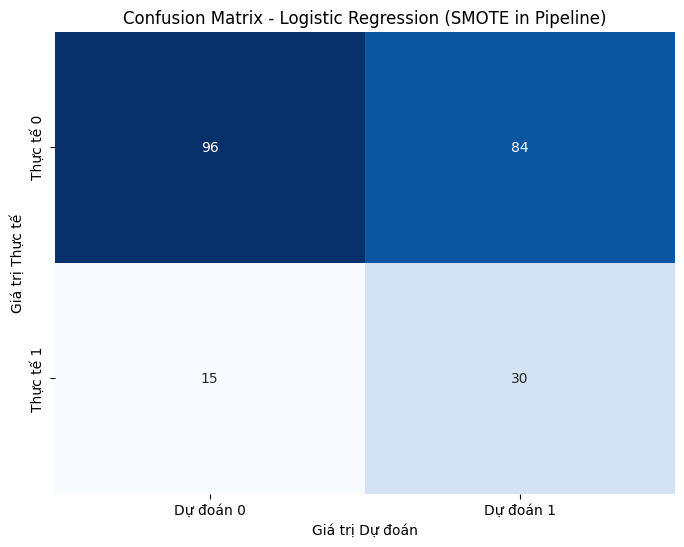


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.53      0.66       180
           1       0.26      0.67      0.38        45

    accuracy                           0.56       225
   macro avg       0.56      0.60      0.52       225
weighted avg       0.74      0.56      0.60       225


ROC AUC: 0.5873


In [37]:
print("\nKết quả Logistic Regression (đã tinh chỉnh với SMOTE trong pipeline) trên tập kiểm tra:")
print("Confusion Matrix:")
cm_lr_smote = confusion_matrix(y_test, y_pred_best_lr_smote)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr_smote, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Dự đoán 0', 'Dự đoán 1'],
            yticklabels=['Thực tế 0', 'Thực tế 1'])
plt.title('Confusion Matrix - Logistic Regression (SMOTE in Pipeline)')
plt.xlabel('Giá trị Dự đoán')
plt.ylabel('Giá trị Thực tế')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best_lr_smote))
roc_auc_best_lr_smote = roc_auc_score(y_test, y_pred_proba_best_lr_smote)
print(f"\nROC AUC: {roc_auc_best_lr_smote:.4f}")

##### Nhận xét về Mô hình Baseline:

Mô hình baseline hiện tại, sau khi được huấn luyện và đánh giá, cho thấy hiệu suất còn hạn chế trong việc dự đoán rủi ro tín dụng.

*   **Điểm nổi bật:**
    *   Mô hình có khả năng khá tốt trong việc xác định khách hàng thực sự rủi ro cao (Recall cho lớp 1 là 0.67). Điều này cho thấy mô hình đã học được một phần tín hiệu từ dữ liệu, có thể là nhờ các kỹ thuật xử lý mất cân bằng dữ liệu đã được áp dụng trên tập huấn luyện.

*   **Hạn chế chính:**
    *   **Precision của lớp rủi ro cao (label 1) rất thấp:** Đây là một điểm yếu đáng kể. Nó có nghĩa là khi mô hình dự đoán một khách hàng là "rủi ro cao", chỉ có 24% trong số đó thực sự là rủi ro cao. Tỷ lệ False Positive (phân loại nhầm khách hàng tốt thành rủi ro) còn rất cao.
    *   **F1-score cho lớp rủi ro cao thấp :** Do Precision thấp, F1-score (là trung bình điều hòa của Precision và Recall) cho lớp quan trọng này cũng bị kéo xuống, cho thấy hiệu suất tổng thể trên lớp thiểu số này chưa tốt.
    *   **ROC AUC chỉ đạt 0.5873:** Chỉ số này đo lường khả năng phân biệt tổng thể của mô hình giữa hai lớp. Giá trị 0.5888 chỉ cao hơn một chút so với 0.5 (mô hình đoán ngẫu nhiên), cho thấy khả năng phân tách của mô hình còn yếu.
    *   **Accuracy tổng thể (0.56) cũng chưa cao,** phản ánh hiệu suất không đồng đều trên các lớp và sự ảnh hưởng của việc tập trung vào lớp thiểu số.

*   **Kết luận:**
    *   Mô hình baseline này cung cấp một điểm tham chiếu ban đầu quan trọng. Tuy nhiên, với các chỉ số hiện tại, đặc biệt là Precision thấp cho việc xác định khách hàng rủi ro cao và ROC AUC chưa ấn tượng, mô hình cần được cải thiện đáng kể để có thể ứng dụng hiệu quả trong thực tế.

### Triển khai mô hình phức tạp hơn: Random Forest

#### Triển khai mô hình random forest cơ bản chưa tinh chỉnh tham số

1. Khởi tạo mô hình

In [38]:
rf_basic = RandomForestClassifier(n_estimators=100, random_state=42)

2. Train model

In [39]:
rf_basic.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [40]:
y_pred_rf_basic = rf_basic.predict(X_test_processed)
y_pred_proba_rf_basic = rf_basic.predict_proba(X_test_processed)[:, 1]

3. Đánh giá mô hình

In [41]:
print("\nKết quả Random Forest (cơ bản) trên tập kiểm tra:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf_basic))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_basic))
roc_auc_rf_basic = roc_auc_score(y_test, y_pred_proba_rf_basic)
print(f"\nROC AUC: {roc_auc_rf_basic:.4f}")


Kết quả Random Forest (cơ bản) trên tập kiểm tra:
Confusion Matrix:
[[157  23]
 [ 36   9]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       180
           1       0.28      0.20      0.23        45

    accuracy                           0.74       225
   macro avg       0.55      0.54      0.54       225
weighted avg       0.71      0.74      0.72       225


ROC AUC: 0.5402


##### Nhận xét về Mô hình Random Forest Cơ bản (Chưa Tinh Chỉnh):

Mô hình Random Forest cơ bản, khi được áp dụng, cho thấy một số thay đổi trong hiệu suất so với mô hình baseline, nhưng chưa đạt được kết quả tối ưu, đặc biệt đối với việc xác định khách hàng rủi ro cao.

*   **Cải thiện ở Lớp Đa số (Label 0 - Rủi ro thấp):**
    *   Mô hình này hoạt động **tốt hơn đáng kể** trong việc xác định khách hàng rủi ro thấp, với Recall tăng từ 0.51 (baseline) lên 0.89 và F1-score tăng từ 0.63 lên 0.85.

*   **Thách thức ở Lớp Thiểu số (Label 1 - Rủi ro cao):**
    *   **Precision (0.28):** Có cải thiện nhẹ so với baseline (0.24), nghĩa là khi dự đoán rủi ro cao, mô hình này ít sai hơn một chút.
    *   **Recall (0.20):** Đây là điểm **suy giảm nghiêm trọng** so với baseline (0.62). Mô hình chỉ phát hiện được 20% khách hàng thực sự rủi ro cao, bỏ sót đến 80%.
    *   **F1-score (0.25):** Do Recall rất thấp, F1-score cho lớp này cũng thấp hơn baseline (0.35), cho thấy hiệu suất tổng thể trên lớp quan trọng này chưa tốt.

*   **Chỉ số Tổng hợp:**
    *   **Accuracy (0.76):** Cao hơn baseline, chủ yếu do hiệu suất tốt trên lớp đa số.
    *   **ROC AUC (0.5541):** Vẫn ở mức rất thấp và không cải thiện so với baseline, cho thấy khả năng phân biệt tổng thể của mô hình còn yếu.

*   **Kết luận:**
    *   Mô hình Random Forest cơ bản, dù cải thiện ở lớp đa số, lại **thất bại trong việc phát hiện phần lớn khách hàng rủi ro cao (Recall lớp 1 rất thấp)**, khiến nó chưa phù hợp để sử dụng.
    *   Hiệu suất kém trên lớp thiểu số và ROC AUC thấp cho thấy mô hình này (với các tham số mặc định) chưa nắm bắt được các yếu tố quan trọng để phân loại rủi ro.
    *   **Cần thiết phải thực hiện tinh chỉnh siêu tham số** cho Random 

#### Thực hiện triển khai mô hình Random Forest sau khi đã tinh chỉnh tham số

1. Khởi tạo mô hình với các tham số cần tìm

In [42]:
pipeline_rf_smote = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

In [43]:
# Định nghĩa lại param_grid cho các tham số của RandomForestClassifier (tiền tố 'rf__')
param_grid_rf_pipeline = {
    'rf__n_estimators': [100, 200], # Giảm bớt để chạy nhanh hơn khi thử nghiệm
    'rf__max_depth': [5, 10, 20, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__class_weight': [None, 'balanced', 'balanced_subsample'] # Thêm class_weight
}

In [44]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scorer_class1 = make_scorer(f1_score, pos_label=1)

In [45]:
grid_search_rf_smote = GridSearchCV(
    estimator=pipeline_rf_smote,
    param_grid=param_grid_rf_pipeline,
    cv=cv_strategy,
    scoring=f1_scorer_class1,
    verbose=1,
    n_jobs=-1
)

2. Train model

In [46]:
grid_search_rf_smote.fit(X_train_processed, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


KeyboardInterrupt: 

In [ ]:
print("\nSiêu tham số tốt nhất cho Random Forest:")
print(grid_search_rf_smote.best_params_)
print(f"F1-score (lớp 1) tốt nhất từ CV: {grid_search_rf_smote.best_score_:.4f}")


Siêu tham số tốt nhất cho Random Forest:
{'rf__class_weight': 'balanced_subsample', 'rf__max_depth': 5, 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
F1-score (lớp 1) tốt nhất từ CV: 0.3604


In [ ]:
best_rf_model_smote_pipeline = grid_search_rf_smote.best_estimator_
y_pred_best_rf_smote = best_rf_model_smote_pipeline.predict(X_test_processed)
y_pred_proba_best_rf_smote = best_rf_model_smote_pipeline.predict_proba(X_test_processed)[:, 1]

3. Đánh giá mô hình

In [ ]:
print("\nKết quả trên tập kiểm tra với Random Forest đã tinh chỉnh:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_rf_smote))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best_rf_smote))

roc_auc_best_rf = roc_auc_score(y_test, y_pred_proba_best_rf_smote)
print(f"\nROC AUC: {roc_auc_best_rf:.4f}")


Kết quả trên tập kiểm tra với Random Forest đã tinh chỉnh:
Confusion Matrix:
[[120  60]
 [ 27  18]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.67      0.73       180
           1       0.23      0.40      0.29        45

    accuracy                           0.61       225
   macro avg       0.52      0.53      0.51       225
weighted avg       0.70      0.61      0.65       225


ROC AUC: 0.5820


-> Có cải thiện nhưng không đáng kể, mặt khác khi ta so sánh với mô hình baseline thì ta thấy f1-score và recal của label 1 còn thấp hơn. Cho thấy hiệu năng không cao của mô hình với tập dữ liệu này

### KẾT LUẬN:
Với lượng thông tin ít ỏi của customer_df mang lại thì ở thời điểm hiện tại tôi chưa tìm được mô hình nào thực hiện tốt trong việc dự đoán. Vậy nên phương hướng cải tiến ở đây tôi đưa ra sẽ là gộp với payment_df thành 1 bảng

## Xử lý theo phương án 2: Dùng toàn bộ tập dữ liệu để dự đoán

To be continue at file "decision_sp_2.ipynb" ...